<a href="https://colab.research.google.com/github/fsternini/nlp-newspaper/blob/development/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# First, verification of Python version is completed
!which python # should return /usr/local/bin/python
!python --version

/usr/local/bin/python
Python 3.10.12


In [25]:
!git clone 'https://github.com/fsternini/nlp-newspaper.git'
%cd 'nlp-newspaper'
# Switch to the most updated branch
!git switch development
# Collect the most updated version of the repo
!git pull

Cloning into 'nlp-newspaper'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 32 (delta 12), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (32/32), 20.72 KiB | 424.00 KiB/s, done.
Resolving deltas: 100% (12/12), done.
/content/nlp-newspaper/nlp-newspaper
Branch 'development' set up to track remote branch 'development' from 'origin'.
Switched to a new branch 'development'
Already up to date.


In [26]:
# Install all requirements for the code
!pip install -r requirements.txt -q
!python -m unidic download
# Google Drive is mounted, to reach all relevant data
from google.colab import drive
import os
import pandas as pd
import colab_env
import matplotlib.pyplot as plt
import seaborn as sns

drive.mount('/content/drive')
dataset_path = os.environ['NLP_DATASET']

  Preparing metadata (setup.py) ... done
download url: https://cotonoha-dic.s3-ap-northeast-1.amazonaws.com/unidic-3.1.0.zip
Dictionary version: 3.1.0+2021-08-31
unidic-3.1.0.zip: 100% 526M/526M [00:06<00:00, 79.9MB/s]
Finished download.
Downloaded UniDic v3.1.0+2021-08-31 to /usr/local/lib/python3.10/dist-packages/unidic/dicdir
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
eng_file_path = dataset_path+'/english_news.csv'
jpn_file_path = dataset_path+'/japanese_news.csv'
english_news = pd.read_csv(eng_file_path, sep='\t')
japanese_news = pd.read_csv(jpn_file_path, sep='\t')

<ipython-input-4-c97bfcc42ecb>:4: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  japanese_news = pd.read_csv(jpn_file_path, sep='\t')


In [5]:
english_news.head()

,source,date,title,author,text
0,Mainichi Shimbun,2021-12-06,"Editorial: Japan govt's 20,000-yen handout mis...",NaN,The Japanese government is trying to boost the...
1,Mainichi Shimbun,2021-12-07,Editorial: Time for Japan PM Kishida to delive...,NaN,"Prime Minister Fumio Kishida, who won a public..."
2,Mainichi Shimbun,2021-12-08,"Editorial: 80 years on from Pearl Harbor, acti...",NaN,It has been 80 years since the start of the Pa...
3,Mainichi Shimbun,2021-12-08,"Yoroku: 80 years later, many lessons still not...",NaN,"""The world has changed completely. The era was..."
4,Mainichi Shimbun,2021-12-08,Promoting respect for human rights behind US '...,NaN,The U.S. administration under President Joe Bi...


In [6]:
japanese_news.head()

,source,date,title,author,text
0,kobe-np.co.jp,2005-07-01,NaN,NaN,会見した北口寛人市長は「刑事訴訟で被告となっている職員にはそれぞれ主張があるが、組織全体とし...
1,kobe-np.co.jp,2005-07-01,NaN,NaN,明石・歩道橋事故をめぐる民事訴訟で、神戸地裁から計五億六千八百万円の賠償を命じられた兵庫県（...
2,kobe-np.co.jp,2007-04-07,NaN,NaN,会見後、遺族代理人の渡部吉泰弁護士は「裁判長が『問うべき者を問わないのは正義に反する』とはっ...
3,kobe-np.co.jp,2007-04-07,NaN,NaN,遺族会は、雑踏警備本部長を務めた元明石署長ら二人の起訴を求め、活動を続けている。
4,kobe-np.co.jp,2007-04-07,NaN,NaN,五人の遺族が閉廷後に会見。二女の優衣菜ちゃん＝当時（８つ）＝を亡くした三木清さん（３８）＝姫...


##English database Exploratory Data Analysis

In [7]:
english_news.count()

source    36889
date      36889
title     36889
author    12846
text      36766
dtype: int64

In [8]:
english_news.isna().sum()

source        0
date          0
title         0
author    24043
text        123
dtype: int64

In [9]:
english_news = english_news.drop('author',axis=1)

In [10]:
english_news = english_news.dropna()

The Japan Times     36692
Mainichi Shimbun       74
Name: source, dtype: int64

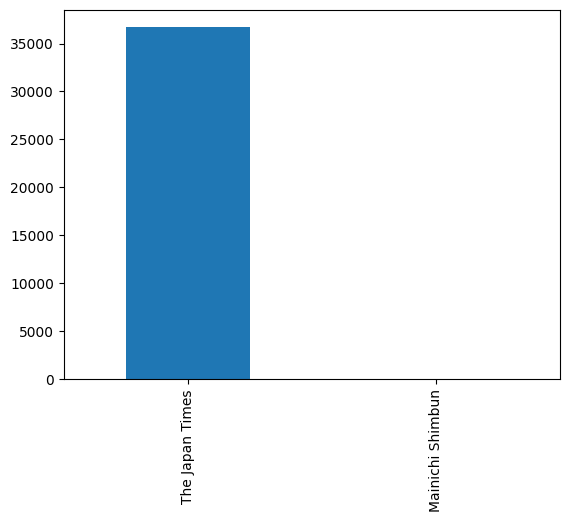

In [11]:
en_source_count = english_news["source"].value_counts()
en_source_count.plot(kind='bar')
en_source_count

## Japanese database exploratory analysis

In [12]:
japanese_news.count()

source    312955
date      312955
title         39
author         1
text      312954
dtype: int64

In [13]:
japanese_news.isna().sum()

source         0
date           0
title     312916
author    312954
text           1
dtype: int64

In [14]:
japanese_news = japanese_news.drop(['author','title'],axis=1)

In [15]:
japanese_news = japanese_news.dropna()

In [16]:
japanese_news.iloc[0]["text"]

'会見した北口寛人市長は「刑事訴訟で被告となっている職員にはそれぞれ主張があるが、組織全体として判決を厳しく受け止めた」と述べた。原告団長の下村誠治さん（４６）＝神戸市垂水区＝も同席。「県警も判決を真摯（しんし）に受け止めて」と訴えた。'

mainichi.jp          44656
sankei.jp.msn.com    35959
nikkei.com           29323
sanspo.com           26303
tomamin.co.jp        26054
nikkansports.com     25483
oita-press.co.jp     23645
yomiuri.co.jp        22472
nishinippon.co.jp    21311
asahi.com            19855
hokkaido-np.co.jp    10653
shimotsuke.co.jp      9581
kobe-np.co.jp         8311
kyoto-np.co.jp        3408
yamagata-np.jp        2585
isenp.co.jp           1496
iwate-np.co.jp        1198
nnn.co.jp              347
tokachi.co.jp          176
chunichi.co.jp          73
tokyo-np.co.jp          65
Name: source, dtype: int64

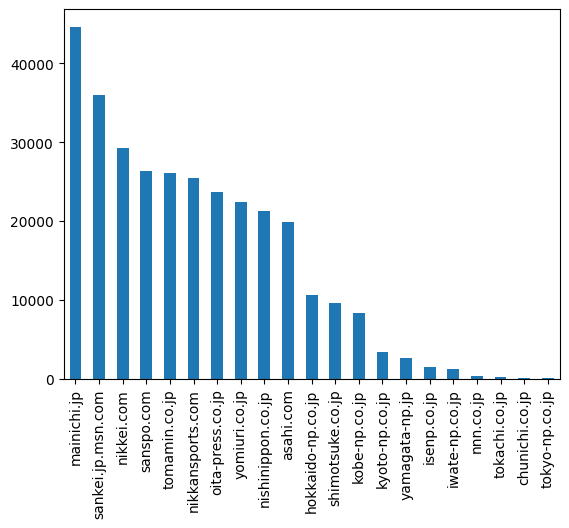

In [17]:
jp_source_count = japanese_news["source"].value_counts()
jp_source_count.plot(kind='bar')
jp_source_count

In [18]:
japanese_news["length"] = japanese_news["text"].str.len()

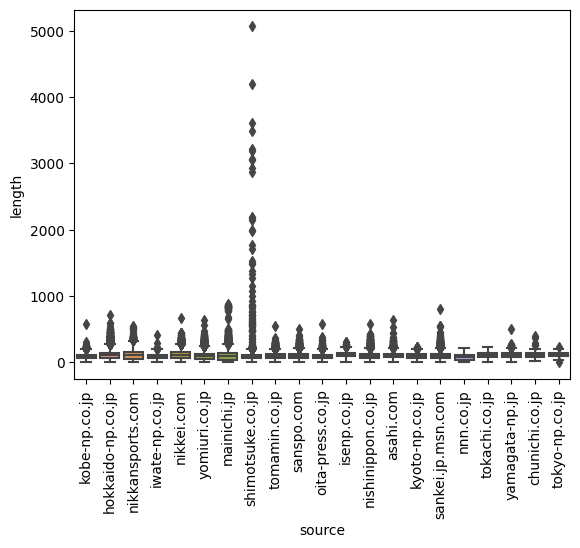

In [19]:
ax = sns.boxplot(data = japanese_news, x='source', y='length')
ax.tick_params(axis='x', labelrotation=90)

<Axes: xlabel='length', ylabel='Density'>

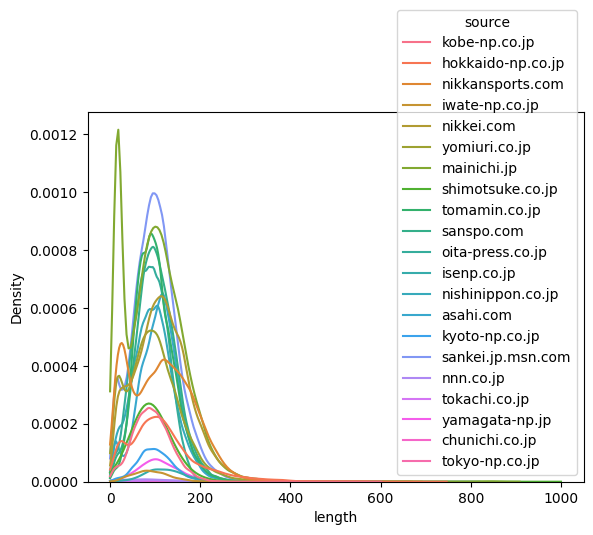

In [20]:
sns.kdeplot(data = japanese_news, x='length',hue=japanese_news['source'], clip=[0,1000])

In [27]:
from fugashi import Tagger

tagger = Tagger('-Owakati')
japanese_news["tokens"] = japanese_news["text"].apply(tagger.parse)
japanese_news.head()

download url: https://cotonoha-dic.s3-ap-northeast-1.amazonaws.com/unidic-3.1.0.zip
Dictionary version: 3.1.0+2021-08-31
unidic-3.1.0.zip: 100% 526M/526M [00:07<00:00, 68.4MB/s]
Finished download.
Downloaded UniDic v3.1.0+2021-08-31 to /usr/local/lib/python3.10/dist-packages/unidic/dicdir


,source,date,text,length,tokens
0,kobe-np.co.jp,2005-07-01,会見した北口寛人市長は「刑事訴訟で被告となっている職員にはそれぞれ主張があるが、組織全体とし...,117,会見 し た 北口 寛人 市長 は 「 刑事 訴訟 で 被告 と なっ て いる 職員 に ...
1,kobe-np.co.jp,2005-07-01,明石・歩道橋事故をめぐる民事訴訟で、神戸地裁から計五億六千八百万円の賠償を命じられた兵庫県（...,105,明石 ・ 歩道 橋 事故 を めぐる 民事 訴訟 で 、 神戸 地裁 から 計 五 億 六千...
2,kobe-np.co.jp,2007-04-07,会見後、遺族代理人の渡部吉泰弁護士は「裁判長が『問うべき者を問わないのは正義に反する』とはっ...,84,会見 後 、 遺族 代理 人 の 渡部 吉 泰 弁護 士 は 「 裁判 長 が 『 問う べ...
3,kobe-np.co.jp,2007-04-07,遺族会は、雑踏警備本部長を務めた元明石署長ら二人の起訴を求め、活動を続けている。,40,遺族 会 は 、 雑踏 警備 本部 長 を 務め た 元 明石 署 長 ら 二人 の 起訴 ...
4,kobe-np.co.jp,2007-04-07,五人の遺族が閉廷後に会見。二女の優衣菜ちゃん＝当時（８つ）＝を亡くした三木清さん（３８）＝姫...,96,五 人 の 遺族 が 閉廷 後 に 会見 。 二女 の 優衣 菜 ちゃん ＝ 当時 （ ８ ...


In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline


X = japanese_news["tokens"]
y = japanese_news["source"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)


In [29]:
X_train.shape

(250363, 123407)

In [30]:
X_test = vectorizer.transform(X_test)

In [31]:
X_test.shape

(62591, 123407)

In [32]:
classifier = SGDClassifier(loss='hinge', penalty='l2',
...                           alpha=1e-3, random_state=42,
...                           max_iter=5, tol=None)

# Step 6: Train the classifier
classifier.fit(X_train, y_train)

# Step 7: Evaluate the performance
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.49066159671518267


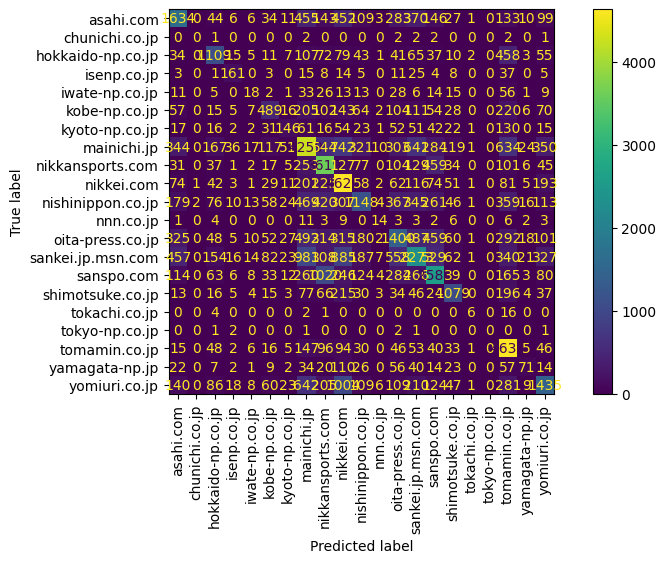

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
ax.tick_params(axis='x', labelrotation=90)

In [35]:
import urllib
from urllib.request import urlopen
import re

# slothlib
slothlib_path = "http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt"
sloth_file = urllib.request.urlopen(slothlib_path)

# stopwordsiso
iso_path = "https://raw.githubusercontent.com/stopwords-iso/stopwords-ja/master/stopwords-ja.txt"
iso_file = urllib.request.urlopen(iso_path)
stopwords = [line.decode("utf-8").strip() for line in iso_file]

stopwords = [ss for ss in stopwords if not ss==u'']
stopwords = list(set(stopwords))


In [36]:

X = japanese_news["tokens"]
y = japanese_news["source"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)
vectorizer = TfidfVectorizer(stop_words=stopwords)
X_train = vectorizer.fit_transform(X_train)

In [37]:
X_train.shape

(250363, 123335)

In [38]:
X_test = vectorizer.transform(X_test)

In [39]:
X_test.shape

(62591, 123335)

In [40]:
classifier = SGDClassifier(loss='hinge', penalty='l2',
...                           alpha=1e-3, random_state=42,
...                           max_iter=5, tol=None)

# Step 6: Train the classifier
classifier.fit(X_train, y_train)

# Step 7: Evaluate the performance
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.4899905737246569


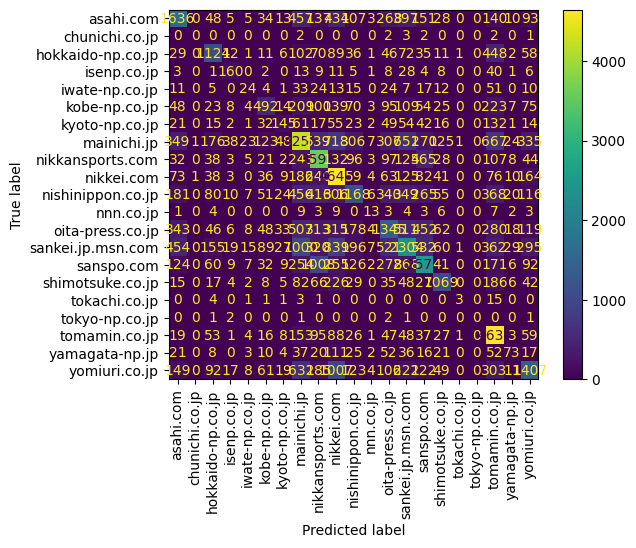

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
ax.tick_params(axis='x', labelrotation=90)